In [1]:
%pylab inline
# import igraph
import matplotlib.pyplot as plt
import sys, os
print(os.getcwd())
sys.path.append('../code')
from rnnmodel import *
from notebookutils import *

Populating the interactive namespace from numpy and matplotlib
/Users/cartergoldman/sussex/variational_vs_sampling/InferringInference/notebooks


## 1. Load in parameters used to generate TAP dynamics

In [6]:
# set noise seed
noise_seed = 2022
np.random.seed(noise_seed)
torch.manual_seed(noise_seed)
print('noise_seed = %d' %(noise_seed))
model_type = 1 # 1: Ux + b, 0: Ux


brain, theta, params = loadbrain("../data/brains/Ns_10_Nr_500_noiseseed_2022",False)

noise_seed = 2022


## 2. Generate training and validation data

In [16]:
B_train, B_val = 2500, 500       # No. of batches; I changed from 25k to 2.5k for training batches. 
                                 # It's also kind of confusing because a single batch is Ns x T 
                                 # instead of multiple Ns x T
                                 # 
T = 30                           # No. of time steps 
T_clip  = 20                     # No. of time steps to clip
T_low, T_high = 2, 5             # range of time periods for which input is held constant
yG_low, yG_high = 2, 50          # range of input gains

y_train, _, r_train = generate_TAPdynamics(theta, params, B_train, T+T_clip, T_low, T_high, yG_low, yG_high)

y_val, _, r_val = generate_TAPdynamics(theta, params, B_val, T+T_clip, T_low, T_high, yG_low, yG_high)

In [17]:
# Add baseline to make neural activity positive

baseline = -np.min(r_train) if model_type else 0
r_train += baseline
r_val += baseline

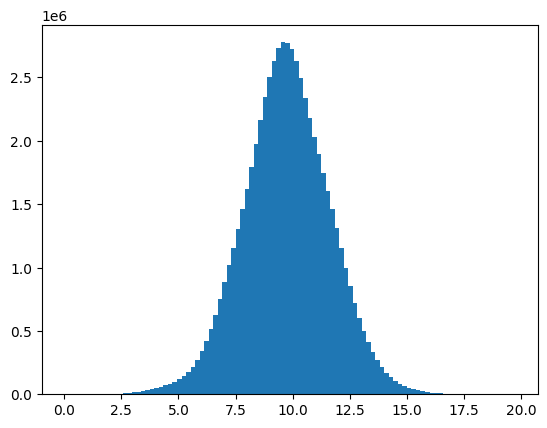

In [18]:
# Plot histogram of training data

plt.hist(r_train.flatten(),100)
plt.show()

In [19]:
"""
Convert ground truth dynamics data to torch tensors
"""    

y_train = torch.tensor(y_train.transpose(0,2,1), dtype=torch.float32) # input signal
r_train = torch.tensor(r_train.transpose(0,2,1), dtype=torch.float32) # target neural activity

y_val = torch.tensor(y_val.transpose(0,2,1), dtype=torch.float32) # input signal
r_val = torch.tensor(r_val.transpose(0,2,1), dtype=torch.float32) # target neural activity


print('No. of batches x T x No. of neurons')
print('Training data:', r_train.shape, 'Validation data:', r_val.shape)

No. of batches x T x No. of neurons
Training data: torch.Size([2500, 50, 500]) Validation data: torch.Size([500, 50, 500])


In [20]:
"""
Convert model to cpu and run the entire training and test data through the model
"""

brain.cpu()
brain.use_cuda = False

with torch.no_grad():
    rhat_val    = brain(y_val)[0]


In [21]:
"""
Convert torch tensors to numpy
"""

del y_train, r_train

y_val    = y_val[:,T_clip:].data.numpy()
r_val    = r_val[:,T_clip:].data.numpy()
rhat_val = rhat_val[:,T_clip:].data.numpy()


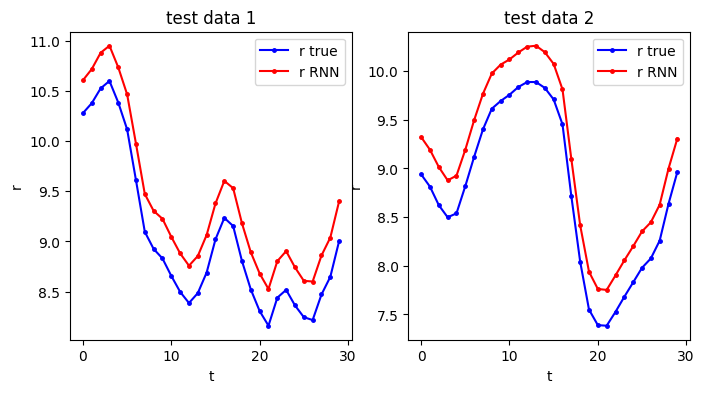

In [22]:
"""
Plot fits to test data
"""
fig, ax = plt.subplots(1,2,figsize=(8,4))

ax[0].plot(r_val[5,:,1],'b.-',markersize=5)
ax[0].plot(rhat_val[5,:,1],'r.-',markersize=5)
ax[0].set(xlabel='t', ylabel='r', title ='test data 1')
ax[0].legend(['r true', 'r RNN'])

ax[1].plot(r_val[2,:,0],'b.-',markersize=5)
ax[1].plot(rhat_val[2,:,0],'r.-',markersize=5)
ax[1].set(xlabel='t', ylabel='r', title ='test data 2')
ax[1].legend(['r true', 'r RNN'])

plt.show()

In [23]:
"""
Generate another test data set
"""

B_test = 5  # No. of batches
T_test = 1000 # No. of time steps 

y_test, _, r_test = generate_TAPdynamics(theta, params, B_test, T_test+T_clip, T_low, T_high, yG_low, yG_high)

r_test = r_test.transpose(0,2,1) + baseline
y_test = torch.tensor(y_test.transpose(0,2,1), dtype=torch.float32) 

print('No. of batches x T x No. of neurons')
print('Test data:', r_test.shape)

No. of batches x T x No. of neurons
Test data: (5, 1020, 500)


In [25]:
"""
Run model on test data
"""
with torch.no_grad():
    rhat_test = brain(y_test)[0]

y_test    = y_test[:,T_clip:].data.numpy()
r_test    = r_test[:,T_clip:]
rhat_test = rhat_test[:,T_clip:].data.numpy()

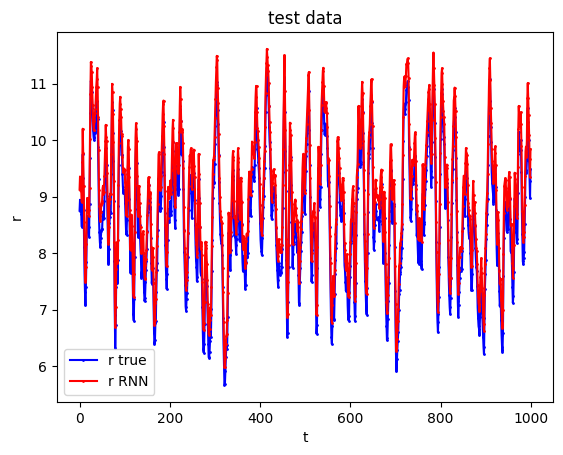

In [26]:
"""
Test data
"""
plt.plot(r_test[0,:,0],'b.-',markersize=2)
plt.plot(rhat_test[0,:,0],'r.-',markersize=2)
plt.xlabel('t')
plt.ylabel('r')
plt.title('test data')
plt.legend(['r true', 'r RNN'])
plt.show()

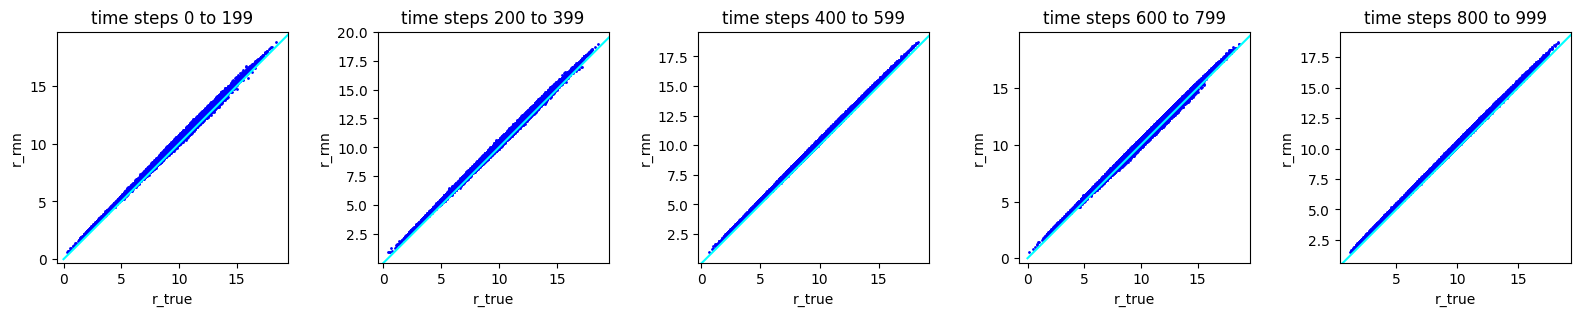

In [27]:
"""
Scatter plot for test data for every C time steps
"""
C = 200
N = T_test//C


fig, ax = plt.subplots(1,N,figsize=(4*N,3))
rmax = np.max(r_test)+2
for ni in range(N):
    ax[ni].plot(r_test[:,ni*C:(ni+1)*C].flatten(), rhat_test[:,ni*C:(ni+1)*C].flatten(),'b.',markersize=2)
    ax[ni].axis('square')
    ax[ni].plot([0,rmax],[0,rmax],color='cyan')
    ax[ni].set(xlabel='r_true', ylabel='r_rnn', title = 'time steps ' +str(ni*C)+ ' to ' + str(ni*C + C-1))